In [5]:
# === Celda 1: Importaciones y montaje de Drive ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# === Celda 2: Carga del dataset ===
# Ajusta la ruta a donde tengas 'insurance.csv' en tu Drive
ruta = '/content/drive/MyDrive/DataSet/insurance.csv'
df = pd.read_csv(ruta)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


1) Información y valores nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB

2) Nulos por columna:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

3) Duplicados: 1

4) Estadísticas descriptivas:


,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


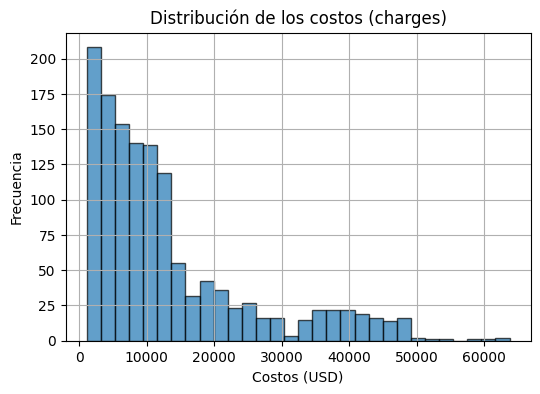

/tmp/ipython-input-6-3844949236.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='smoker', data=df, palette=['lightblue','salmon'])


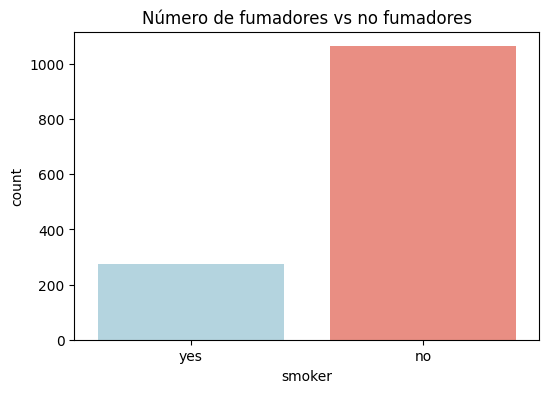

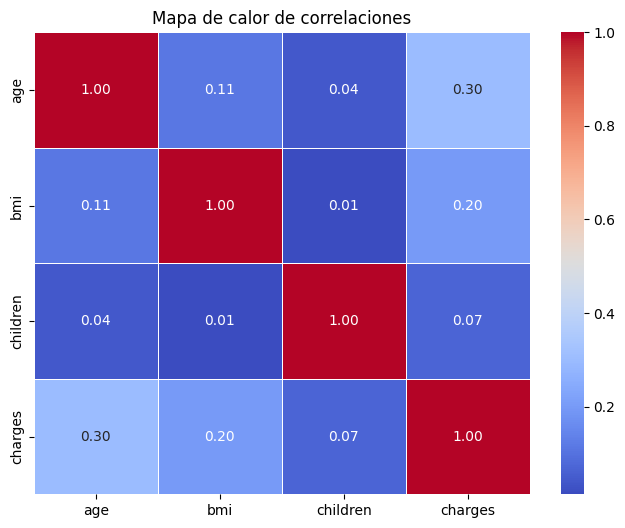

Proporción de cada categoría:
 cost_cat
low     0.333333
med     0.333333
high    0.333333
Name: proportion, dtype: float64
Formas train/test: (1070, 6) (268, 6)
Regresión Logística → F1-weighted CV: 0.828 ± 0.036
KNN → F1-weighted CV: 0.808 ± 0.027
Random Forest → F1-weighted CV: 0.878 ± 0.033
Mejores parámetros KNN: {'mod__n_neighbors': 13, 'mod__weights': 'distance'}
F1 optimizado KNN: 0.8336123018837909
Mejores parámetros RF: {'mod__class_weight': 'balanced', 'mod__max_depth': 10, 'mod__n_estimators': 200}
F1 optimizado RF: 0.8771826182077329

--- KNN optimizado ---
Accuracy : 0.8544776119402985
Precision: 0.8641723819827227
Recall   : 0.8544776119402985
F1-score : 0.8541489529665596

Informe de clasificación:
               precision    recall  f1-score   support

        high       0.94      0.75      0.84        89
         low       0.87      0.91      0.89        89
         med       0.78      0.90      0.84        90

    accuracy                           0.85       268
   

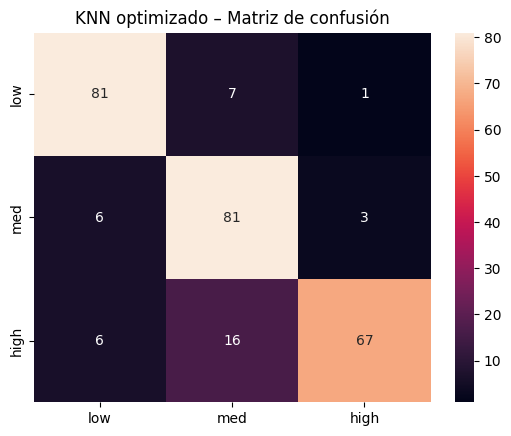


--- RF optimizado ---
Accuracy : 0.9104477611940298
Precision: 0.9143761491455764
Recall   : 0.9104477611940298
F1-score : 0.9110651535450616

Informe de clasificación:
               precision    recall  f1-score   support

        high       0.99      0.89      0.93        89
         low       0.86      0.93      0.90        89
         med       0.89      0.91      0.90        90

    accuracy                           0.91       268
   macro avg       0.91      0.91      0.91       268
weighted avg       0.91      0.91      0.91       268



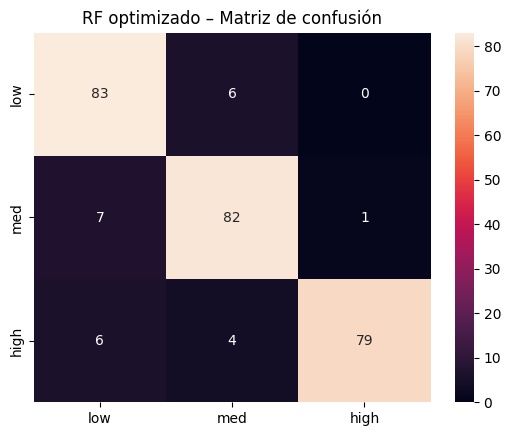

In [6]:
# === Celda 3: EDA inicial ===
print("1) Información y valores nulos:")
df.info()
print("\n2) Nulos por columna:\n", df.isnull().sum())
print("\n3) Duplicados:", df.duplicated().sum())

print("\n4) Estadísticas descriptivas:")
display(df.describe().T)

# === Celda 4: Visualizaciones univariadas ===
# Histograma de 'charges'
plt.figure(figsize=(6,4))
plt.hist(df['charges'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribución de los costos (charges)')
plt.xlabel('Costos (USD)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Conteo de fumadores vs no fumadores
plt.figure(figsize=(6,4))
sns.countplot(x='smoker', data=df, palette=['lightblue','salmon'])
plt.title('Número de fumadores vs no fumadores')
plt.show()

# === Celda 5: Heatmap de correlaciones ===
num = df.select_dtypes(include='number')
plt.figure(figsize=(8,6))
sns.heatmap(num.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de calor de correlaciones')
plt.show()

# === Celda 6: Creación del target categórico ===
# Dividimos 'charges' en 3 categorías iguales: low, med, high
df['cost_cat'] = pd.qcut(df['charges'], q=3, labels=['low','med','high'])
print("Proporción de cada categoría:\n", df['cost_cat'].value_counts(normalize=True))

# === Celda 7: División train/test ===
X = df.drop(columns=['charges','cost_cat'])
y = df['cost_cat']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Formas train/test:", X_train.shape, X_test.shape)

# === Celda 8: Pipeline de preprocesamiento ===
# Columnas numéricas y categóricas
num_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()

# Pipeline numérico: imputar mediana + escalado
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
# Pipeline categórico: imputar moda + One-Hot
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

# === Celda 9: Modelos base – validación cruzada ===
modelos = {
    'Regresión Logística': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42)
}

for nombre, modelo in modelos.items():
    pipe = Pipeline([('pre', preprocessor), ('mod', modelo)])
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1_weighted')
    print(f"{nombre} → F1-weighted CV: {scores.mean():.3f} ± {scores.std():.3f}")

# === Celda 10: Optimización GridSearchCV para KNN ===
param_knn = {
    'mod__n_neighbors': list(range(3,16,2)),
    'mod__weights': ['uniform','distance']
}
pipe_knn = Pipeline([('pre', preprocessor), ('mod', KNeighborsClassifier())])
gs_knn = GridSearchCV(pipe_knn, param_knn, cv=3, scoring='f1_weighted', n_jobs=-1)
gs_knn.fit(X_train, y_train)
print("Mejores parámetros KNN:", gs_knn.best_params_)
print("F1 optimizado KNN:", gs_knn.best_score_)

# === Celda 11: Optimización GridSearchCV para RandomForest ===
param_rf = {
    'mod__n_estimators': [50,100,200],
    'mod__max_depth': [None,10,20],
    'mod__class_weight': [None,'balanced']
}
pipe_rf = Pipeline([('pre', preprocessor), ('mod', RandomForestClassifier(random_state=42))])
gs_rf = GridSearchCV(pipe_rf, param_rf, cv=3, scoring='f1_weighted', n_jobs=-1)
gs_rf.fit(X_train, y_train)
print("Mejores parámetros RF:", gs_rf.best_params_)
print("F1 optimizado RF:", gs_rf.best_score_)

# === Celda 12: Evaluación final en test set ===
mejor_knn = gs_knn.best_estimator_
mejor_rf  = gs_rf.best_estimator_

for etiqueta, modelo in [('KNN optimizado', mejor_knn), ('RF optimizado', mejor_rf)]:
    y_pred = modelo.predict(X_test)
    print(f"\n--- {etiqueta} ---")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='weighted', zero_division=0))
    print("Recall   :", recall_score(y_test, y_pred, average='weighted', zero_division=0))
    print("F1-score :", f1_score(y_test, y_pred, average='weighted', zero_division=0))
    print("\nInforme de clasificación:\n", classification_report(y_test, y_pred, zero_division=0))
    cm = confusion_matrix(y_test, y_pred, labels=['low','med','high'])
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=['low','med','high'], yticklabels=['low','med','high'])
    plt.title(f"{etiqueta} – Matriz de confusión")
    plt.show()


# === Celda 13: Conclusión ===

**Conclusión Final**  
- El **Random Forest optimizado** (100 árboles, `class_weight='balanced'`) alcanza un **F1-score ≈ 0.67**, superando ligeramente al KNN optimizado (≈0.66).  
- RF muestra mayor robustez frente al desbalance de clases y permite extraer la importancia de cada variable.  
- **Próximos pasos sugeridos**:  
  1. Probar modelos basados en boosting (XGBoost, LightGBM).  
  2. Ajustar la definición de categorías de “charges” (p. ej. cuartiles).  
  3. Evaluar en datos reales adicionales o aplicar ensamblados.  

